In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RepeatedKFold, KFold
from scipy.stats import zscore

In [2]:
DIRECTORY = './data/'
calendar = pd.read_csv(DIRECTORY + 'calendar.csv', parse_dates=['date'])
train_validation = pd.read_csv(DIRECTORY + 'sales_train_validation.csv')
prices = pd.read_csv(DIRECTORY + 'sell_prices.csv')

## Setup row-wise DF

In [3]:
train_validation[[f'd_{i}' for i in range(1914, 1942)]] = np.nan
train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
drop_cols = [f'd_{i}' for i in range(1, 1100)]
train_validation = train_validation.drop(columns=drop_cols, errors='ignore')

In [5]:
# Convert to row wise
row_wise = train_validation.copy()
row_wise = row_wise.melt(id_vars=[col for col in train_validation.columns if 'id' in col], var_name='day', value_name='sales')

# Change all object cols to category
for col in row_wise.select_dtypes('object').columns:
    row_wise[col] = row_wise[col].astype('category')

In [6]:
# Merge calendar
calendar['d'] = calendar['d'].astype('category')
row_wise = row_wise.merge(calendar[['date', 'wm_yr_wk', 'event_name_1', 'snap_CA', 'snap_TX', 'snap_WI', 'd']],\
                how='left', left_on='day', right_on='d')

In [7]:
# Merge in sale price
row_wise = row_wise.merge(prices, how='left', on=['store_id', 'item_id', 'wm_yr_wk'])

In [8]:
# Save data
for col in row_wise.select_dtypes('object'):
    row_wise[col] = row_wise[col].astype('category')
for col in row_wise.select_dtypes('int'):
    row_wise[col] = pd.to_numeric(row_wise[col], downcast='integer')
for col in row_wise.select_dtypes('float'):
    row_wise[col] = pd.to_numeric(row_wise[col], downcast='float')
row_wise.dtypes

id                    category
item_id               category
dept_id               category
cat_id                category
store_id              category
state_id              category
day                   category
sales                  float32
date            datetime64[ns]
wm_yr_wk                 int16
event_name_1          category
snap_CA                   int8
snap_TX                   int8
snap_WI                   int8
d                     category
sell_price             float32
dtype: object

In [9]:
# Drop no sale price cols
row_wise['sell_price'].isna().value_counts()
row_wise = row_wise[row_wise['sell_price'].notna()]

## Feature Engineering

In [10]:
# Filter days
row_wise['day'] = row_wise['day'].str.split('_').str[1].astype(int)
test_start = 1159+28
row_wise = row_wise[row_wise['day'] >= test_start]

In [11]:
# Make single SNAP column
state_map = {"CA": 0, "WI": 1, "TX": 2}
snap_values = row_wise[["snap_CA", "snap_WI", "snap_TX"]].to_numpy()
row_wise['snap'] = snap_values[np.arange(len(row_wise)), row_wise["state_id"].map(state_map).to_numpy()]
del state_map, snap_values

In [12]:
# Delete useless features
useless = ['d', 'snap_CA', 'snap_TX', 'snap_WI']
row_wise = row_wise.drop(columns=useless)

In [13]:
# Basic event features
def add_event_features(df):
    df['is_event'] = df['event_name_1'].notna()

    event_per_day = df.groupby("day")["event_name_1"].first()
    df["event_name_tmrw"] = df["day"].map(event_per_day.shift(-1))
    df["event_name_yday"] = df["day"].map(event_per_day.shift(1))

    df["is_event_tmrw"] = df["event_name_tmrw"].notna()
    df["is_event_yday"] = df["event_name_yday"].notna()

add_event_features(row_wise)

In [14]:
def add_date_features(df):
    df['day_of_week'] = df['date'].dt.day_of_week
    df['year'] = df['date'].dt.year
    df['year_sin'] = np.sin(2*np.pi * df['date'].dt.day / 365)
    df['year_cos'] = np.cos(2*np.pi * df['date'].dt.day / 365)
    df['month'] = df['date'].dt.month

add_date_features(row_wise)

In [15]:
def add_price_features(df):
    group = df.groupby("id")["sell_price"]
    mean_per_id = group.transform('mean')
    std_per_id = group.transform('std').fillna(0)
    df["sell_price_zscore"] = np.where(std_per_id == 0, 0, (df['sell_price'] - mean_per_id)/std_per_id)

    def add_detrended_zscore(groups):
        if not groups: groups = []
        groups = groups + ['wm_yr_wk']

        avg_zscore_group = df.groupby(groups)["sell_price_zscore"].transform("mean")
        df[f"sell_price_zscore_{'_'.join(groups)}"]  = df['sell_price_zscore'] / avg_zscore_group

    for groups in [None]: add_detrended_zscore(groups)

add_price_features(row_wise)

/tmp/ipykernel_336898/435921784.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby("id")["sell_price"]


In [16]:
def add_sales_features(df):
    df["ewm_sales_alpha_005"] = df.groupby("id")["sales"].transform(lambda x: x.ewm(alpha=0.05).mean())
    df['ewm_sales_alpha_005'] = df.groupby('id')['ewm_sales_alpha_005'].shift(1).fillna(0)

    df['zero_sales'] = df['sales'] == 0
    df["ewm_zero_sales_alpha_005"] = df.groupby("id")["zero_sales"].transform(lambda x: x.ewm(alpha=0.05).mean())
    df["ewm_zero_sales_alpha_005"] = df.groupby("id")["ewm_zero_sales_alpha_005"].shift(1).fillna(1)

    # group = df.groupby("id")["sales"]
    # mean_per_id = group.transform('mean')
    # std_per_id = group.transform('std').fillna(0)
    # df["sales_zscore"] = np.where(std_per_id == 0, 0, (df['sales'] - mean_per_id)/std_per_id)

    # def rolling_avg_zscore(group_col):
    #     if group_col is None: group_col = ['id']

    #     # Step 1: Compute daily average z-score per group
    #     daily_avg_zscore = df.groupby(group_col + ["day"])["sales_zscore"].mean().reset_index()
    #     daily_avg_zscore['sales_zscore_7d_avg'] = daily_avg_zscore.groupby(group_col)["sales_zscore"].transform(lambda x: x.rolling(7, min_periods=1).mean())

    #     df[f"sales_zscore_rolling7_{'_'.join(group_col)}"] = df.groupby(group_col)["sales_zscore"].transform(lambda x: x.rolling(7, min_periods=1, closed='left').mean())
    # for group in [None, ['dept_id', 'store_id']]:
    #     rolling_avg_zscore(group)

# Zero out sales for test period
add_sales_features(row_wise)

/tmp/ipykernel_336898/3678531056.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["ewm_sales_alpha_005"] = df.groupby("id")["sales"].transform(lambda x: x.ewm(alpha=0.05).mean())
/tmp/ipykernel_336898/3678531056.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['ewm_sales_alpha_005'] = df.groupby('id')['ewm_sales_alpha_005'].shift(1).fillna(0)
/tmp/ipykernel_336898/3678531056.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

## Modelling

In [19]:
# Remove leakage cols
drop_cols = ['sales_zscore', 'sales_zscore_rolling7_id', 'sales_zscore_rolling7_dept_id_store_id', 'date', 'zero_sales', 'zero_sales_yday']
row_wise = row_wise.drop(columns=drop_cols, errors='ignore')
row_wise.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'day',
       'sales', 'wm_yr_wk', 'event_name_1', 'sell_price', 'snap', 'is_event',
       'event_name_tmrw', 'event_name_yday', 'is_event_tmrw', 'is_event_yday',
       'day_of_week', 'year', 'year_sin', 'year_cos', 'month',
       'sell_price_zscore', 'sell_price_zscore_wm_yr_wk',
       'ewm_sales_alpha_005', 'ewm_zero_sales_alpha_005'],
      dtype='object')

In [20]:
test_start = 1913+1
train = row_wise[row_wise['day'] < test_start]
test = row_wise[row_wise['day'] >= test_start]

# id_cols = [col for col in train if 'id' in col]
# train[id_cols] = train[id_cols].astype('category')
# test[id_cols] = test[id_cols].astype('category')

In [21]:
import os
import multiprocessing
import xgboost as xgb
from sklearn.model_selection import KFold
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed

def train_store(store_id, train, test, gpu_id):
    # Filter data for the current store.
    train_store = train[train['store_id'] == store_id].copy()
    test_store = test[test['store_id'] == store_id].copy()

    # Prepare test features and target.
    X_test = test_store.drop(columns=['sales'])
    y_test = test_store['sales']

    # Prepare dataframes to store predictions.
    oof_preds = pd.DataFrame(index=train_store.index, columns=['prediction', 'actual'])
    oof_preds['actual'] = train_store['sales']
    
    n_splits = 2
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    test_preds = pd.DataFrame(index=test_store.index, columns=[f'fold_{i}' for i in range(n_splits)])
    test_preds['actual'] = y_test

    # Set up XGBoost parameters.
    params = {
        'n_estimators': 5000,
        'learning_rate': 0.1,
        'verbosity': 0,
        'enable_categorical': True,
        'early_stopping_rounds': 10,
        'random_state': 42,
        'objective': 'reg:tweedie',
        'tweedie_variance_power': 1.3,
        'eval_metric': 'rmse',
        'reg_lambda': 0,
        'min_child_weight': 1,
        'tree_method': 'gpu_hist',
        'gpu_id': gpu_id
    }

    # Run KFold training for the store's data.
    for i, (train_idx, val_idx) in enumerate(kf.split(train_store)):
        X_train = train_store.iloc[train_idx].drop(columns=['sales'])
        y_train = train_store.iloc[train_idx]['sales']
        X_val = train_store.iloc[val_idx].drop(columns=['sales'])
        y_val = train_store.iloc[val_idx]['sales']
        
        model = xgb.XGBRegressor(**params)
        print(f"training w/ store_id {store_id}, gpu_id {gpu_id}, fold {i}")
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=None)
        
        # Generate predictions and clip at 0.
        oof_preds.iloc[val_idx, 0] = model.predict(X_val).clip(0)
        test_preds[f'fold_{i}'] = model.predict(X_test).clip(0)

    print(f"completed w/ store_id {store_id}, gpu_id {gpu_id}, fold {i}")
    return store_id, oof_preds, test_preds

if __name__ == '__main__':
    # Assume that train and test are already defined Pandas DataFrames.
    # They must include the columns 'sales' and 'store_id'.
    
    # Define the number of GPUs available.
    num_gpus = 5  # Change this to the number of GPUs you have.

    # Get all unique store IDs.
    store_ids = train['store_id'].unique()

    # Prepare tasks for each store. We assign GPUs in a round-robin fashion.
    tasks = []
    for i, store_id in enumerate(store_ids):
        gpu_id = i % num_gpus
        tasks.append((store_id, train, test, gpu_id))
    
    # Use ProcessPoolExecutor and executor.map to run tasks in parallel.
    results = []
    with ProcessPoolExecutor(max_workers=len(tasks)) as executor:
        # Submit all tasks.
        futures = [executor.submit(train_store, *task) for task in tasks]
        
        # Collect results as they complete.
        for future in as_completed(futures):
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Error occurred: {e}")

    # Optionally, you can combine oof_preds and test_preds from each store.
    combined_oof = pd.concat([res[1] for res in results])
    combined_test = pd.concat([res[2] for res in results])
    
    # Example: print store IDs that were processed.
    for store_id, _, _ in results:
        print(f"Completed training for store_id: {store_id}")
        

training w/ store_id CA_1, gpu_id 0, fold 0
training w/ store_id CA_2, gpu_id 1, fold 0
training w/ store_id CA_3, gpu_id 2, fold 0
training w/ store_id CA_4, gpu_id 3, fold 0
training w/ store_id TX_1, gpu_id 4, fold 0
training w/ store_id TX_2, gpu_id 0, fold 0
training w/ store_id CA_2, gpu_id 1, fold 1
training w/ store_id CA_1, gpu_id 0, fold 1
training w/ store_id CA_4, gpu_id 3, fold 1
training w/ store_id TX_3, gpu_id 1, fold 0
training w/ store_id WI_1, gpu_id 2, fold 0
training w/ store_id TX_1, gpu_id 4, fold 1
training w/ store_id WI_2, gpu_id 3, fold 0
completed w/ store_id CA_4, gpu_id 3, fold 1
training w/ store_id WI_3, gpu_id 4, fold 0
training w/ store_id CA_3, gpu_id 2, fold 1
completed w/ store_id TX_1, gpu_id 4, fold 1
training w/ store_id TX_2, gpu_id 0, fold 1
training w/ store_id WI_2, gpu_id 3, fold 1
training w/ store_id TX_3, gpu_id 1, fold 1
completed w/ store_id CA_2, gpu_id 1, fold 1
training w/ store_id WI_3, gpu_id 4, fold 1
training w/ store_id WI_1, gp

In [22]:
oof_rmses = []
test_rmses = []
oof_dfs = []
test_dfs = []

for store_id, oof_preds, test_preds in results:
    oof_rmse = root_mean_squared_error(oof_preds['prediction'], oof_preds['actual'])
    print(store_id, oof_rmse)

    oof_rmses.append(oof_rmse)
    oof_dfs.append(oof_preds)
    test_dfs.append(test_preds)

print("combined oof:", np.sqrt(np.mean(pd.Series(oof_rmses)**2)))
print("combined test:", np.sqrt(np.mean(pd.Series(test_rmses)**2)))
oof_preds = pd.concat(oof_dfs)
test_preds = pd.concat(test_dfs)

CA_4 1.4099739789962769
TX_1 1.8461933135986328
CA_2 1.8104723691940308
WI_2 2.6035571098327637
TX_3 1.9885891675949097
TX_2 2.097038984298706
CA_1 2.212836503982544
WI_3 1.8840810060501099
CA_3 2.980908155441284
WI_1 1.6665494441986084
combined oof: 2.0955773115634404
combined test: nan


In [23]:
# Real metric
test['predictions'] = (test_preds['fold_0'] + test_preds['fold_1'])/2
# test['predictions'] = test_preds['fold_1']

/tmp/ipykernel_336898/2520718987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = (test_preds['fold_0'] + test_preds['fold_1'])/2


In [24]:
predictions = test.pivot(index='id', columns='day', values='predictions')
predictions = predictions.rename(columns={col : f'd_{col}' for col in predictions.columns})
predictions.to_csv('test_prediction.csv')

In [25]:
predictions.columns=[f'F{i}' for i in range(1, 29)]

In [26]:
train_evaluation = pd.read_csv(DIRECTORY + 'sales_train_evaluation.csv')
train_evaluation

predictions = pd.concat([predictions.reset_index(), train_evaluation[['id']]])
predictions = predictions.fillna(0)
predictions.to_csv('./xgb.csv', index=False)

In [27]:
predictions

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.674948,0.638823,0.639935,0.648495,0.781074,1.032631,1.054187,0.757198,0.738316,...,0.812710,1.062311,1.056284,0.713468,0.673767,0.672655,0.678490,0.810052,1.060987,1.056155
1,FOODS_1_001_CA_2_validation,0.767415,0.768579,0.821847,0.839393,1.016283,1.348894,1.310108,0.928594,0.980477,...,1.039523,1.401680,1.390176,0.860100,0.856495,0.856789,0.871512,1.044642,1.417276,1.407101
2,FOODS_1_001_CA_3_validation,0.875271,1.023124,1.039132,1.068731,1.057312,1.307800,1.770571,1.080652,1.097350,...,1.183397,1.521927,1.687503,1.052969,0.993679,0.985438,1.008575,1.175024,1.508354,1.674506
3,FOODS_1_001_CA_4_validation,0.459315,0.406873,0.401054,0.400082,0.381837,0.429705,0.467257,0.523677,0.474241,...,0.447161,0.507491,0.499015,0.489870,0.435790,0.420491,0.423151,0.445211,0.506409,0.504184
4,FOODS_1_001_TX_1_validation,0.152022,0.186034,0.178944,0.181858,0.190839,0.200918,0.254456,0.212884,0.235218,...,0.215747,0.221728,0.235497,0.203240,0.197306,0.187945,0.189571,0.198098,0.217663,0.219622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30486,FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30487,FOODS_3_825_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30488,FOODS_3_826_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## SHAP

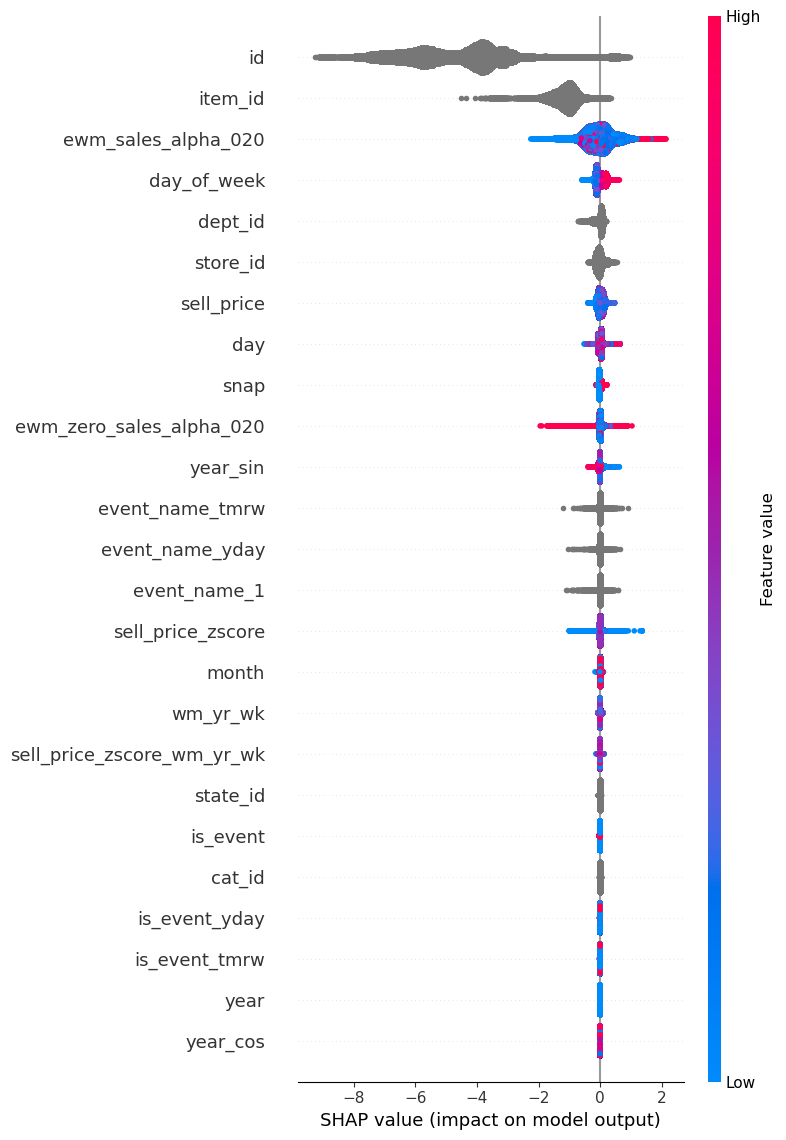

In [28]:
from xgboost import DMatrix
import shap
shap.initjs()

test_dm = DMatrix(X_test, enable_categorical=True)
shap_values = xgb_model.get_booster().predict(test_dm, pred_contribs=True)
shap.summary_plot(shap_values[:,:-1], X_test, max_display=40)